<a href="https://colab.research.google.com/github/KartikGarg20526/Emoji-Prediction-using-twitter-data/blob/main/Emoji_detection_DL_Bidirectional_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re
from textblob import TextBlob
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import tensorflow as tf
from tensorflow import keras

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Load Data

In [ ]:
tweet_txt_raw = open('/content/us_train.text','r',encoding="utf8")
tweet_labels_raw = open('/content/us_train.labels','r',encoding="utf8")

tweet_text = []
tweet_labels = []

for sentence in tweet_txt_raw:
    sentence = sentence.rstrip()
    tweet_text.append(sentence)

for sentence in tweet_labels_raw:
    sentence = sentence.rstrip()
    sentence = int(sentence)
    tweet_labels.append(sentence)

df = pd.DataFrame()
df["Tweet"] = tweet_text
df["Label"] = tweet_labels

In [ ]:
df.head()

,Tweet,Label
0,A little throwback with my favourite person @ ...,0
1,glam on @user yesterday for #kcon makeup using...,7
2,Democracy Plaza in the wake of a stunning outc...,11
3,Then &amp; Now. VILO @ Walt Disney Magic Kingdom,0
4,Who never... @ A Galaxy Far Far Away,2


In [ ]:
print("Shape of the dataset : ", df.shape)

Shape of the dataset :  (50000, 2)


# Emoji Mapping

In [ ]:
emoji_raw = open('/content/us_mapping.txt','r',encoding="utf8")

emoji = []
label = []
meaning = []
for sentence in emoji_raw:
    print(sentence)
    sentence = sentence.rstrip()
    label.append(sentence.split()[0])
    emoji.append(sentence.split()[1])
    meaning.append(sentence.split()[2:])

emoji_map = pd.DataFrame()
emoji_map['Label'] = label
emoji_map['Emoji'] = emoji
emoji_map['Meaning'] = meaning

0	❤️	 Red heart	

1	😍	 Smiling face with hearteyes	

2	😂	 Face with tears of joy	

3	💕	 Two hearts

4	🔥	 Fire

5	😊	 Smiling face with smiling eyes	

6	😎	 Smiling face with sunglasses	

7	✨	 Sparkles 	

8	💙	 Blue heart

9	😘	 Face blowing a kiss	

10	📷	 Camera	

11	🇺🇸	 United States	

12	☀️	 Sun

13	💜	 Purple heart 	

14	😉	 Winking face	

15	💯	 Hundred points	

16	😁	 Beaming face with smiling eyes	

17	🎄	Christmas tree	

18	📸	Camera with flash

19	😜	Winking face with tongue	



In [ ]:
print(emoji_map)

   Label Emoji                               Meaning
0      0    ❤️                          [Red, heart]
1      1     😍      [Smiling, face, with, hearteyes]
2      2     😂          [Face, with, tears, of, joy]
3      3     💕                         [Two, hearts]
4      4     🔥                                [Fire]
5      5     😊  [Smiling, face, with, smiling, eyes]
6      6     😎     [Smiling, face, with, sunglasses]
7      7     ✨                            [Sparkles]
8      8     💙                         [Blue, heart]
9      9     😘              [Face, blowing, a, kiss]
10    10     📷                              [Camera]
11    11    🇺🇸                      [United, States]
12    12    ☀️                                 [Sun]
13    13     💜                       [Purple, heart]
14    14     😉                       [Winking, face]
15    15     💯                     [Hundred, points]
16    16     😁  [Beaming, face, with, smiling, eyes]
17    17     🎄                     [Christmas,

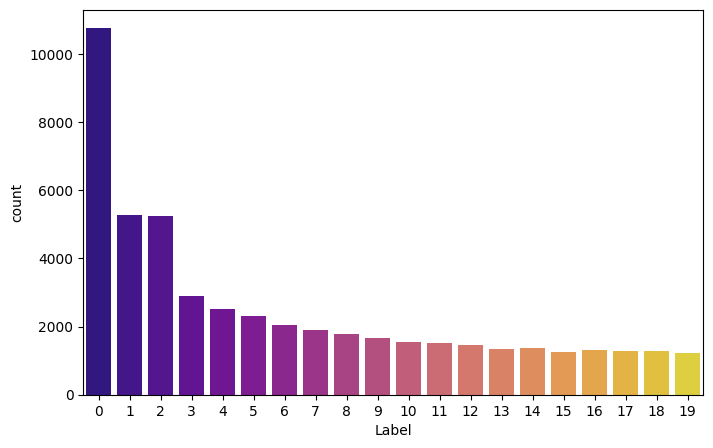

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x=df['Label'], palette="plasma")
plt.show()

In [ ]:
# Checking if our data has duplicated rows
print("Duplicated Rows : ", df.duplicated().sum())

Duplicated Rows :  116


In [ ]:
# Dropping duplicated rows
df = df.drop_duplicates()

In [ ]:
# Reseting the indexes after dropping some rows
df = df.reset_index(drop=True)

In [ ]:
print("Shape of the data : ", df.shape)

Shape of the data :  (49884, 2)


Checking of there is some correlation between tweet length and Label data

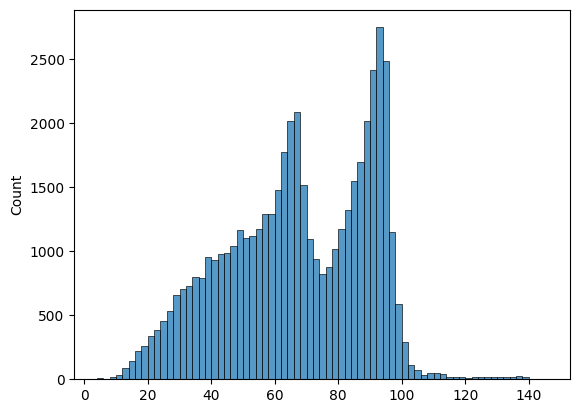

In [ ]:
tweet_len = []
for sen in df['Tweet']:
  tweet_len.append(len(sen))

new_df = pd.DataFrame()
new_df['Tweet_Length'] = tweet_len

sns.histplot(tweet_len)
plt.show()

In [ ]:
corr = df['Label'].corr(new_df['Tweet_Length'])
print("Correlation between tweet length and label : ", corr)

Correlation between tweet length and label :  0.023448833195926666


Correlation between Tweet length and Label is very low.

# Preprocessing

In [ ]:
def lowercase(tweet):
  tweet = str(tweet)
  return tweet.lower()

In [ ]:
def remove_html_tags(tweet):
    tweet = str(tweet)
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', tweet)

In [ ]:
def remove_url(tweet):
    tweet = str(tweet)
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', tweet)

In [ ]:
def remove_punctuations(tweet):
    tweet = str(tweet)
    exclude = string.punctuation
    return tweet.translate(str.maketrans('', '', exclude))

In [ ]:
def remove_mentions(tweet):
    return re.sub(r'@[A-Za-z0-9_]+', '', tweet)

In [ ]:
def remove_stopwords(tweet):
    tweet = str(tweet)
    tweet_words = []

    for word in tweet.split():
        if word in stopwords.words('english'):
            tweet_words.append('')
        else:
            tweet_words.append(word)
    return ' '.join(tweet_words)

In [ ]:
def remove_numbers(tweet):
    tweet = str(tweet)
    return re.sub(r'\d+', '', tweet)

In [ ]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for w in word_tokenize(text):
        lemmatized_words.append(lemmatizer.lemmatize(w))
    return " ".join(lemmatized_words)

In [ ]:
def preprocessing(data):
  df['Tweet'] = df['Tweet'].apply(lowercase)            # converting to lowercase
  df['Tweet'] = df['Tweet'].apply(remove_html_tags)     # removing html tags
  df['Tweet'] = df['Tweet'].apply(remove_url)           # removing Urls
  df['Tweet'] = df['Tweet'].apply(remove_punctuations)  # removing punctutations
  df['Tweet'] = df['Tweet'].apply(remove_mentions)      # removing @ mentions
  df['Tweet'] = df['Tweet'].apply(remove_stopwords)     # removing stopwords
  df['Tweet'] = df['Tweet'].apply(remove_numbers)       # removing numbers
  df['Tweet'] = df['Tweet'].apply(lemmatize_text)       # applying lemmatization

In [ ]:
preprocessing(df)

In [ ]:
df.head()

,Tweet,Label
0,little throwback favourite person water wall,0
1,glam user yesterday kcon makeup using user fea...,7
2,democracy plaza wake stunning outcome decision...,11
3,amp vilo walt disney magic kingdom,0
4,never galaxy far far away,2


# Sentiment Analysis

In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00


In [ ]:
analyzer = SentimentIntensityAnalyzer()
sentiment_score = []
for tweet in df['Tweet']:
  sentiment = analyzer.polarity_scores(tweet)['compound']
  if sentiment >= 0.5:
    sentiment_score.append(1)
  elif sentiment <= -0.5:
    sentiment_score.append(-1)
  else:
    sentiment_score.append(0)

print(sentiment_score)

In [ ]:
new_df = pd.DataFrame()
new_df['Tweet'] = df['Tweet']
new_df['Sentiment_Score'] = sentiment_score
new_df['Label'] = df['Label']
print(new_df.shape)

(49884, 3)


In [ ]:
new_df.sample(5)

,Tweet,Sentiment_Score,Label
2061,people absolute favorite willowood ranch,0,3
21915,old friend amp new friend one year friendship ...,1,0
3486,fool stop pop roll spot every day others chunk…,-1,2
12178,somewhere hill clothing user colorado spring c...,0,18
20774,hoco chateau elan winery amp resort,0,0


In [ ]:
corr = new_df['Label'].corr(new_df['Sentiment_Score'])

In [ ]:
print("Correlation between Sentiment of the tweet and label : ", corr)

Correlation between Sentiment of the tweet and label :  -0.06495911462472476


Correlation between sentiment of the tweet and label is very low so we will discard it as our feature.

In [ ]:
X = df['Tweet'].values
y = df['Label'].values

# Over-sampling data

In [ ]:
df['Label'].value_counts()

0     10728
1      5263
2      5237
3      2881
4      2513
5      2312
6      2043
7      1884
8      1791
9      1667
10     1541
11     1518
12     1460
14     1375
13     1346
16     1306
18     1284
17     1276
15     1246
19     1213
Name: Label, dtype: int64

In [ ]:
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler()
X = X.reshape(X.shape[0],1)
X, y = os.fit_resample(X, y)
X = X.reshape(X.shape[0],)
print(X.shape, y.shape)

(214560,) (214560,)


# Tokenization

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

In [ ]:
for i in range(10):
  print("Tweet:", X[i])
  print("Tokenized Text:", sequences[i])

Tweet: little throwback favourite person water wall
Tokenized Text: [29, 367, 1655, 366, 547, 654]
Tweet: glam user yesterday kcon makeup using user featherette…
Tokenized Text: [3515, 1, 209, 21515, 583, 1541, 1, 21516]
Tweet: democracy plaza wake stunning outcome decision nbc news
Tokenized Text: [4087, 621, 1055, 1148, 6562, 2551, 4568, 1428]
Tweet: amp vilo walt disney magic kingdom
Tokenized Text: [7, 47035, 476, 76, 161, 278]
Tweet: never galaxy far far away
Tokenized Text: [91, 2656, 675, 675, 468]
Tweet: dinner fla tonight panseared salmon couscous veggie salad yum dinner florida salmon…
Tokenized Text: [170, 15671, 47, 41816, 2807, 41817, 3405, 1740, 1875, 170, 58, 41818]
Tweet: fav senior last game congrats beating west west salem…
Tokenized Text: [466, 408, 26, 111, 511, 5946, 152, 152, 8017]
Tweet: got go formal best friend phi mu jsu
Tokenized Text: [19, 42, 1092, 21, 24, 977, 3822, 25161]
Tweet: cause miss little homies throwback cousinlove indiana university
Tokenized Te

In [ ]:
max_length = max(len(seq) for seq in sequences)
print("Length of the longest tweet : ", max_length)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

Length of the longest tweet :  23


In [ ]:
print("Number of unique words in vocalbulary : ", len(tokenizer.word_index))

Number of unique words in vocalbulary :  59964


In [ ]:
print("Padded Sequence : ", padded_sequences[0])

Padded Sequence :  [  29  367 1655  366  547  654    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)
print("Training X Dim ",X_train.shape)
print("Training y Dim ",y_train.shape)
print("Test X Dim ",X_test.shape)
print("Test y Dim ",y_test.shape)

Training X Dim  (171648, 23)
Training y Dim  (171648,)
Test X Dim  (42912, 23)
Test y Dim  (42912,)


# LSTMs Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM, Embedding, BatchNormalization

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=30,input_length=X_train.shape[1]))
model.add(LSTM(units = 80, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units = 40))
model.add(Dropout(0.5))
model.add(Dense(units=20, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 30)            1798950   
                                                                 
 lstm (LSTM)                 (None, 23, 80)            35520     
                                                                 
 dropout (Dropout)           (None, 23, 80)            0         
                                                                 
 lstm_1 (LSTM)               (None, 40)                19360     
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 20)                820       
                                                                 
Total params: 1854650 (7.07 MB)
Trainable params: 185465

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics=["accuracy"])

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=1,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, callbacks=callback)

Epoch 1/20
5364/5364 [==============================] - 289s 52ms/step - loss: 2.3255 - accuracy: 0.2739 - val_loss: 1.6817 - val_accuracy: 0.4788
Epoch 2/20
5364/5364 [==============================] - 264s 49ms/step - loss: 1.3462 - accuracy: 0.6012 - val_loss: 1.0882 - val_accuracy: 0.6753
Epoch 3/20
5364/5364 [==============================] - 256s 48ms/step - loss: 0.8887 - accuracy: 0.7496 - val_loss: 0.8456 - val_accuracy: 0.7568
Epoch 4/20
5364/5364 [==============================] - 253s 47ms/step - loss: 0.6569 - accuracy: 0.8185 - val_loss: 0.7067 - val_accuracy: 0.7993
Epoch 5/20
5364/5364 [==============================] - 257s 48ms/step - loss: 0.5157 - accuracy: 0.8594 - val_loss: 0.6569 - val_accuracy: 0.8242
Epoch 6/20
5364/5364 [==============================] - 265s 49ms/step - loss: 0.4183 - accuracy: 0.8869 - val_loss: 0.5665 - val_accuracy: 0.8513
Epoch 7/20
5364/5364 [==============================] - 264s 49ms/step - loss: 0.3515 - accuracy: 0.9047 - val_loss: 0

# Model Evaluation

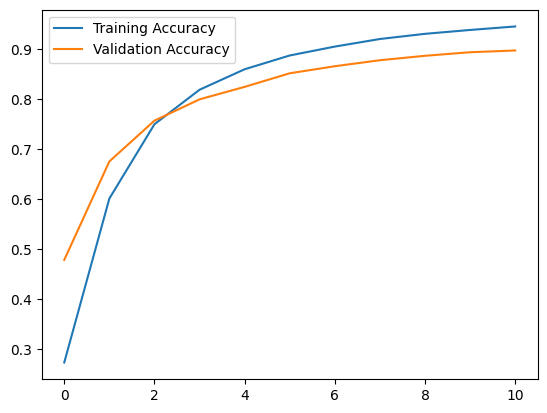

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

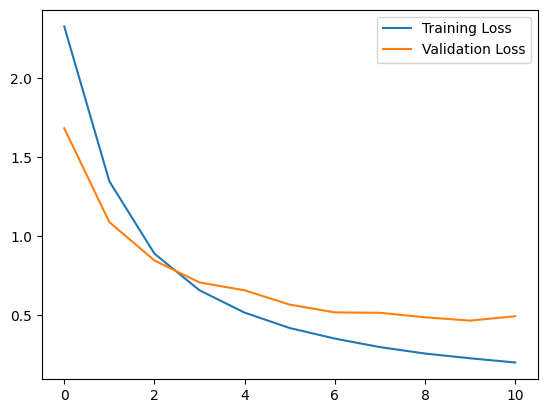

In [ ]:
plt.plot(history.history['loss'],  label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [ ]:
y_pred = model.predict(X_test)

1341/1341 [==============================] - 15s 10ms/step


In [ ]:
y_pred.shape

(42912, 20)

In [ ]:
y_predicted = []
for i in range(y_pred.shape[0]):
  y_predicted.append(np.argmax(y_pred[i]))

print(len(y_predicted))

42912


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.53      0.35      0.42      2100
           1       0.73      0.68      0.70      2090
           2       0.81      0.77      0.79      2178
           3       0.80      0.85      0.83      2158
           4       0.90      0.94      0.92      2072
           5       0.92      0.87      0.89      2141
           6       0.92      0.92      0.92      2117
           7       0.85      0.95      0.90      2171
           8       0.88      0.94      0.91      2156
           9       0.89      0.93      0.91      2198
          10       0.97      0.98      0.98      2112
          11       0.92      0.97      0.94      2167
          12       0.95      0.97      0.96      2066
          13       0.92      0.96      0.94      2134
          14       0.94      0.97      0.95      2146
          15       0.98      0.96      0.97      2259
          16       0.97      0.97      0.97      2197
          17       0.96    

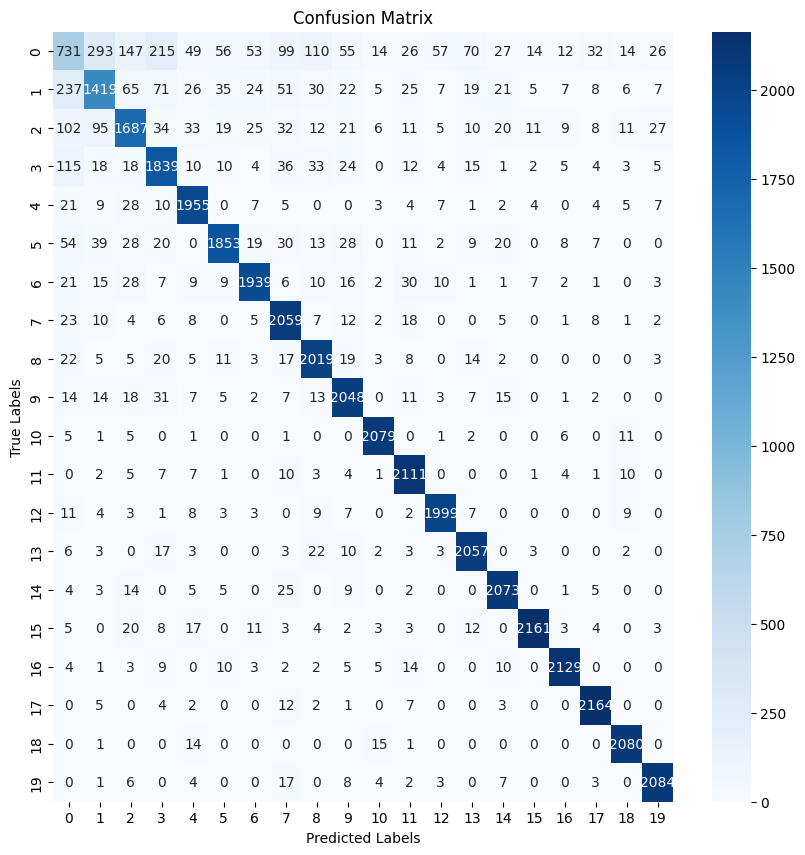

In [ ]:
conf_matrix = confusion_matrix(y_test, y_predicted)
plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[i for i in range(20)], yticklabels=[i for i in range(20)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Bidirectional LSTMs Model

In [ ]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=40,input_length=X_train.shape[1]))
model.add(Bidirectional(LSTM(units = 80, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units = 40)))
model.add(Dropout(0.5))
model.add(Dense(units=20, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 23, 40)            2398600   
                                                                 
 bidirectional_2 (Bidirecti  (None, 23, 160)           77440     
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 23, 160)           0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 80)                64320     
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 20)               

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, callbacks=callback)

Epoch 1/20
5364/5364 [==============================] - 462s 85ms/step - loss: 1.9748 - accuracy: 0.4032 - val_loss: 1.1969 - val_accuracy: 0.6538
Epoch 2/20
5364/5364 [==============================] - 462s 86ms/step - loss: 0.8794 - accuracy: 0.7515 - val_loss: 0.7279 - val_accuracy: 0.7902
Epoch 3/20
5364/5364 [==============================] - 435s 81ms/step - loss: 0.5399 - accuracy: 0.8456 - val_loss: 0.5530 - val_accuracy: 0.8436
Epoch 4/20
5364/5364 [==============================] - 434s 81ms/step - loss: 0.3805 - accuracy: 0.8927 - val_loss: 0.4700 - val_accuracy: 0.8720
Epoch 5/20
5364/5364 [==============================] - 435s 81ms/step - loss: 0.2844 - accuracy: 0.9204 - val_loss: 0.4297 - val_accuracy: 0.8894
Epoch 6/20
5364/5364 [==============================] - 436s 81ms/step - loss: 0.2213 - accuracy: 0.9391 - val_loss: 0.4003 - val_accuracy: 0.9013
Epoch 7/20
5364/5364 [==============================] - 433s 81ms/step - loss: 0.1785 - accuracy: 0.9505 - val_loss: 0

# Model Evaluation

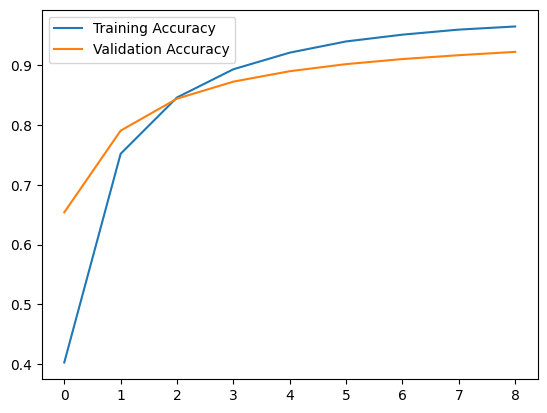

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

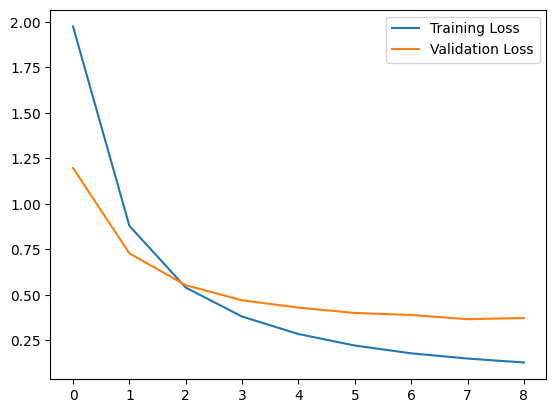

In [ ]:
plt.plot(history.history['loss'],  label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [ ]:
y_pred = model.predict(X_test)

1341/1341 [==============================] - 23s 16ms/step


In [ ]:
y_pred.shape

(42912, 20)

In [ ]:
y_predicted = []
for i in range(y_pred.shape[0]):
  y_predicted.append(np.argmax(y_pred[i]))

print(len(y_predicted))

42912


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.63      0.37      0.47      2100
           1       0.78      0.73      0.76      2090
           2       0.84      0.80      0.82      2178
           3       0.86      0.90      0.88      2158
           4       0.95      0.96      0.95      2072
           5       0.92      0.93      0.93      2141
           6       0.91      0.96      0.94      2117
           7       0.90      0.97      0.93      2171
           8       0.94      0.95      0.94      2156
           9       0.94      0.97      0.96      2198
          10       0.98      0.99      0.98      2112
          11       0.95      0.99      0.97      2167
          12       0.96      0.99      0.98      2066
          13       0.91      0.99      0.95      2134
          14       0.97      0.98      0.98      2146
          15       0.97      0.97      0.97      2259
          16       0.97      0.99      0.98      2197
          17       0.98    

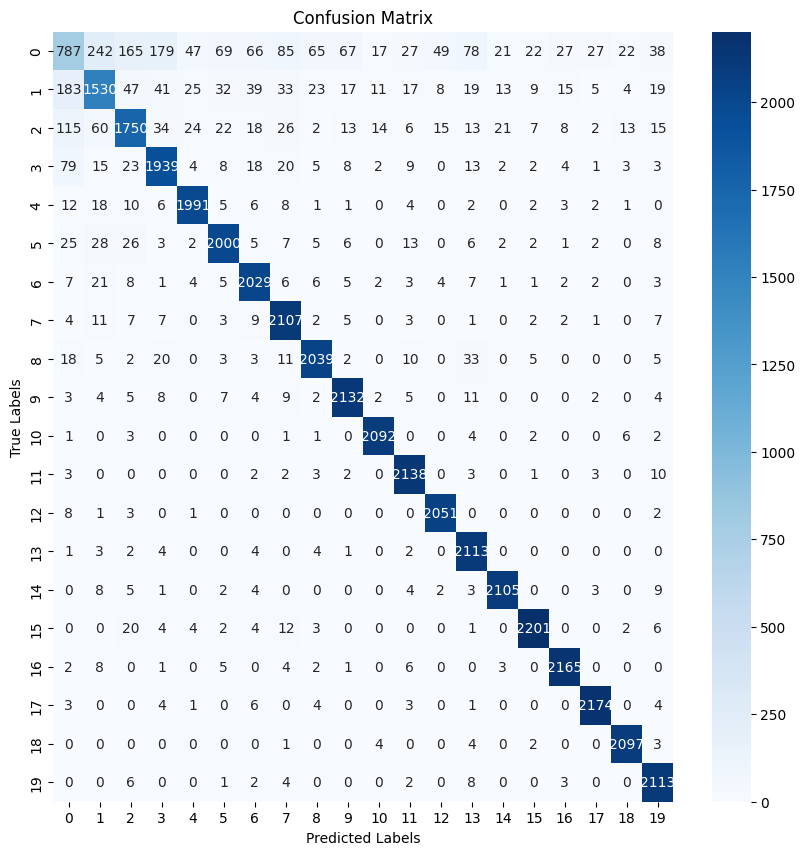

In [ ]:
conf_matrix = confusion_matrix(y_test, y_predicted)
plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[i for i in range(20)], yticklabels=[i for i in range(20)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()